# Определение возраста по фотографии - PhotoAge

Сетевой мегамаркет «Лучшие продукты» внедряет систему компьютерного зрения для определения возраста покупателей по фотографиям.<br>
Фотографии с камер в зоне касс помогут определять возраст покупателей, чтобы:
-	анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
-	контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит возраст человека. Для проекта подготовлен набор фотографий людей с указанием возраста.

Требования к модели:
1. Построить и обучить свёрточную нейронную сеть на датасете с фотографиями людей.
2. Значение метрики MAE на тестовой выборке должно быть не больше 8.

# Исследовательский анализ данных

Импортируем библиотеки и функции, используемые в проекте:

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Прочитаем файл 'labels.csv' и сохраним его в переменной df_labels, а также выведем на экран общую информацию и первые 5 строк датафрейма df_labels:

In [2]:
df_labels = pd.read_csv('/datasets/faces/labels.csv')
df_labels.info()
df_labels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Построим график распределения возраста в выборке и выведем на экран числовое описание данных для столбца real_age (возраст):

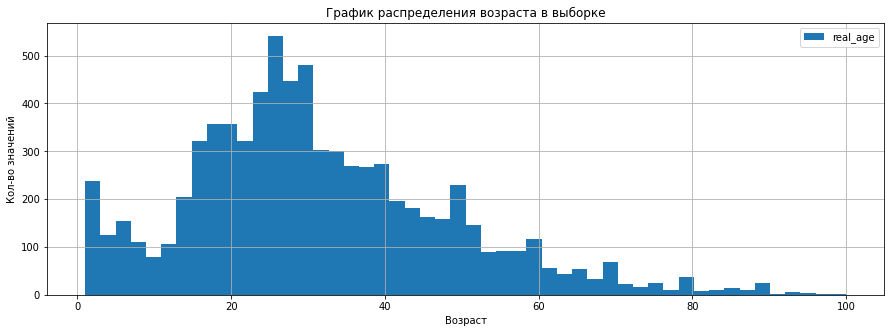

Числовое описание данных для столбца real_age:


count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [3]:
# Построим график распределения возраста в выборке
ax = df_labels['real_age'].plot(title='График распределения возраста в выборке', kind='hist', grid=True, legend=True,
                                bins=50, figsize=(15, 5))
ax.set_xlabel('Возраст')
ax.set_ylabel('Кол-во значений')
plt.show()

# Выведем на экран числовое описание данных для столбца real_age (возраст)
print('Числовое описание данных для столбца real_age:')
df_labels['real_age'].describe()

Загрузим фотографии людей в датафрейм в формате numpy array, обеспечим связь фотографий и возраста людей (целевой признак), а также выведем на экран 15 фотографий и значений возраста людей:

Found 7591 validated image filenames.
features.shape: (16, 150, 150, 3)
target.shape: (16,)


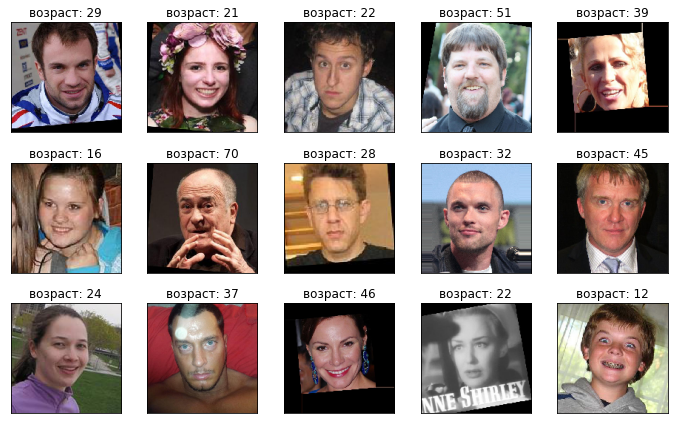

In [4]:
datagen = ImageDataGenerator(rescale=1/255.)
datagen_flow = datagen.flow_from_dataframe(
    dataframe=df_labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    class_mode='raw',
    target_size=(150,150),
    batch_size=16,
    validate_filenames=True)

features, target = next(datagen_flow)
print('features.shape:', features.shape)
print('target.shape:', target.shape)

# Выведем на экран 15 фотографий с указанием возраста
fig = plt.figure(figsize=(10,6))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.title('возраст: ' + str(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод:**

По результатам исследовательского анализа данных можно сделать следующие выводы:
1. Для исследования представлены 7591 файл фотографий людей и информация о возрасте людей, изображенных на этих фотографиях. Связь имен файлов фотографий (поле file_name) с возрастом людей (поле real_age) представлена в датафрейме df_labels. Всего в датафрейме 7591 запись, пропуски в данных отсутствуют.
2. Минимальный возраст человека на фотографии 1 год, максимальный - 100 лет, в среднем - 31 год. График распределения возраста скошен вправо.
3. Переменная datagen_flow содержит датафрейм с фотографиями людей в формате numpy array (признаки модели) и список возрастов, соответствующий фотографиям (целевой признак модели).
4. В связи с тем, что на фотографиях люди изображены с разных ракурсов, часть лица может быть закрыта другими объектами на фотографии, не всегда изображено фото лица (на ряде фотографий люди изображены в полный рост, при этом лицо сильно удалено), поэтому данные недостатки приведут к снижению качества обучения модели.  

# Обучение модели

Создадим функции для:
- загрузки обучающих и тестовых данных с фотографиями и значениями возраста людей;
- создания и обучения модели свёрточной нейронной сети ResNet50.

In [ ]:
def load_train(path):
    df_labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=df_labels,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        target_size=(150,150),
        batch_size=32,
        validate_filenames=True,
        subset='training',
        seed=12345)

    return train_datagen_flow


def load_test(path):
    df_labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=df_labels,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        target_size=(150,150),
        batch_size=32,
        validate_filenames=True,
        subset='validation',
        seed=12345)

    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))

    optimizer = Adam(lr=0.0007)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    model.summary()
    
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=6,
                steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              shuffle=True)
    
    return model

# Вывод на экран результата создания и обучения модели

Using TensorFlow backend.<br>
Found 5694 validated image filenames.<br>
Found 1897 validated image filenames.<br>

Model: "sequential"

| Layer(type)                        | Output Shape                 | Param #           |
|:-----------------------------------|:-----------------------------|:-----------------:|
| resnet50 (Model)                   | (None, 7, 7, 2048)           | 23587712          |
| global_average_pooling2d           | (None, 2048)                 | 0                 |
| dense (Dense)                      | (None, 1)                    | 2049              |

Total params: 23,589,761<br>
Trainable params: 23,536,641<br>
Non-trainable params: 53,120<br>

Train for 178 steps, validate for 60 steps<br>
Epoch 1/6<br>
178/178 - 44s - loss: 201.3510 - mae: 10.6667 - val_loss: 342.7641 - val_mae: 13.7472<br>
Epoch 2/6<br>
178/178 - 36s - loss: 109.6301 - mae: 7.9727 - val_loss: 405.1521 - val_mae: 15.1258<br>
Epoch 3/6<br>
178/178 - 36s - loss: 77.4309 - mae: 6.7842 - val_loss: 362.9005 - val_mae: 14.1536<br>
Epoch 4/6<br>
178/178 - 36s - loss: 51.3488 - mae: 5.5175 - val_loss: 223.1525 - val_mae: 11.2803<br>
Epoch 5/6<br>
178/178 - 35s - loss: 32.4569 - mae: 4.4314 - val_loss: 130.6948 - val_mae: 8.9067<br>
Epoch 6/6<br>
178/178 - 35s - loss: 24.0517 - mae: 3.7851 - val_loss: 96.8766 - val_mae: 7.6179<br>

60/60 - 9s - loss: 96.8766 - mae: 7.6179<br>
Test MAE: 7.6179

# Анализ модели и вывод проекта

Загружены обучающая и тестовая выборки: обучающая выборка содержит 5694 фотографии (75%), тестовая выборка содержит 1897 фотографий (25%).

Для решения задачи проекта была создана модель сверточной нейронной сети ResNet50 со следующими параметрами:
- используется предобученная на ImageNet сеть ResNet50 без "верхушки";
- в качестве "верхушки" созданы 2 слоя:
    - GlobalAveragePooling2D («глобальный двумерный пулинг усреднением», возвращает среднее значение из группы пикселей внутри канала; нужен, чтобы усреднить информацию по всему изображению, то есть получить пиксель с большим количеством каналов: 512 для ResNet50);
    - Dense (полносвязный слой с одним нейроном и функцией активации 'relu').
- используется оптимизатор Adam с learning rate = 0.0007;
- в качестве функции потерь используется mean_squared_error (MSE);
- в качестве метрики рассчитывается значение MAE.

По результатам обучения модели значение метрики MAE на тестовой выборке = 7.6 (данное значение соответствует условиям проекта: значение метрики MAE на тестовой выборке должно быть не больше 8). Данное значение метрики получили при обучении за 6 эпох.

Полученная модель определяет возраст человека с погрешностью в 7.6 лет, поэтому для людей в возрасте от 10 до 25 лет включительно периодически будет требоваться ручная проверка возраста для продажи алкоголя. В связи с тем, что в выборке в указанном диапазоне возраста около 32% людей, то в целом рекомендовать бизнесу данную модель для внедрения не целесообразно (затраты на разработку, внедрение и сопровождение сервиса маловероятно, что будут дешевле ручной проверки покупателей).